In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import Parameter
from qiskit.visualization import *

### Hybrid Quantum - Classical Convolutional Neural Network  

#### Defining a wrapper class for interaction with quantum circuit

In [2]:
class QCircuit:
    
    def __init__(self, n_qubits, backend, iterations):
        self._circuit = QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        
        self.backend = backend
        self.iterations = iterations
    
    def run(self, thetas):
        job = execute(self._circuit, 
                      self.backend, 
                      shots = self.iterations,
                      parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probabilities = counts / self.iterations
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

#### Let's give it a go

Expected value for rotation pi 0.45


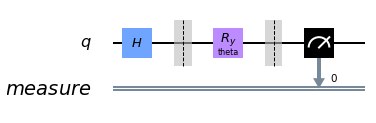

In [3]:
simulator = Aer.get_backend('qasm_simulator')

circuit = QCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

#### Defining a custom hybrid PyTorch layer 

In [4]:
class Quantum(Function):

    @staticmethod
    def forward(ctx, input):
        if not hasattr(ctx, 'circuit'):
            simulator = Aer.get_backend('qasm_simulator')
            ctx.s = np.pi / 2
            ctx.circuit = QCircuit(1, simulator, 100)

        expectation_z = ctx.circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.s
        shift_left = input_list - np.ones(input_list.shape) * ctx.s
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.circuit.run(shift_right[i])
            expectation_left = ctx.circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float()

### Loading the dataset

In [5]:
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

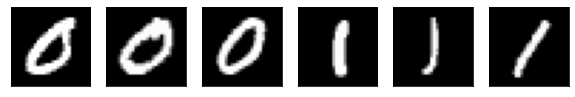

In [6]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, _ = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    
    n_samples_show -= 1

In [7]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Overall network definition

In [8]:
quantum = Quantum.apply 

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = quantum(x)
        x = torch.cat((x, 1 - x), -1)
        return x

In [9]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # Training
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.7055
Training [10%]	Loss: -0.8145
Training [15%]	Loss: -0.8318
Training [20%]	Loss: -0.8593
Training [25%]	Loss: -0.8495
Training [30%]	Loss: -0.8656
Training [35%]	Loss: -0.8628
Training [40%]	Loss: -0.8720
Training [45%]	Loss: -0.8592
Training [50%]	Loss: -0.8822
Training [55%]	Loss: -0.8792
Training [60%]	Loss: -0.8730
Training [65%]	Loss: -0.8766
Training [70%]	Loss: -0.9190
Training [75%]	Loss: -0.9212
Training [80%]	Loss: -0.9128
Training [85%]	Loss: -0.9397
Training [90%]	Loss: -0.9311
Training [95%]	Loss: -0.9564
Training [100%]	Loss: -0.9387


Text(0, 0.5, 'Neg Log Likelihood Loss')

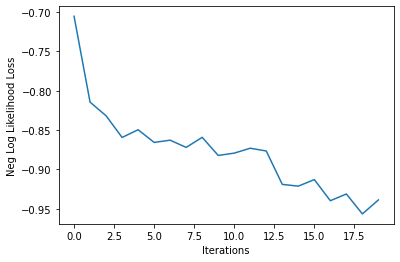

In [27]:
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [30]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance\tLoss: {:.4f}\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance	Loss: -0.8801	Accuracy: 100.0%


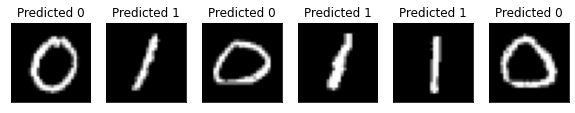

In [31]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

### Literature:

1. Abraham Asfaw et al., Learn Quantum Computation Using Qiskit, 2020, https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html